## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [5]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [6]:
import simulators.mass_function_n_counts.simulator_trapz_tinker as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [7]:
lower = np.array([0.1125, 0.020, 0.6])
upper = np.array([0.1275, 0.024, 1.1])
prior = priors.Uniform(lower, upper)

In [8]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76])


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [9]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker.py'>

In [10]:
N_countsSimulator = n_counts_simulator.Model()

In [11]:
N_countsSimulator.N_counts

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [12]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [13]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

## Fisher contours

### Derivative (five-point stencil)

In [14]:
def compute_derivative(theta_fiducial, param_index, delta_param, log10masses = np.linspace(14, 15.5, num = 4),
                       z_min = np.linspace(0.1, 0.9, num = 5), z_max = np.linspace(0.2, 1.0, num = 5)):
    
    log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))
    
    theta_2h = theta_fiducial
    theta_2h[param_index] = theta_2h[param_index] + 2*delta_param
    counts_2h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_2h)
    
    theta_h = theta_fiducial
    theta_h[param_index] = theta_h[param_index] + delta_param
    counts_h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_h)
    
    theta_h_neg = theta_fiducial
    theta_h_neg[param_index] = theta_h_neg[param_index] - delta_param
    counts_h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_h_neg)
    
    
    theta_2h_neg = theta_fiducial
    theta_2h_neg[param_index] = theta_2h_neg[param_index] - 2*delta_param
    counts_2h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_2h_neg)
    
    deriv = (-counts_2h + 8*counts_h - 8*counts_h_neg + counts_2h_neg)/(12*delta_param)
    
    return deriv
    

### Covariance matrix

In [15]:
cov_matrix = np.diag(np.sqrt(N_countsSimulator.N_counts))

### $\Omega_{cdm}h^{2}$

In [16]:
omega_cdm_steps = np.linspace(0.01, 0.1, 10)*theta_fiducial[0]
omega_cdm_steps

array([0.001197, 0.002394, 0.003591, 0.004788, 0.005985, 0.007182,
       0.008379, 0.009576, 0.010773, 0.01197 ])

In [17]:
for i in range(len(omega_cdm_steps)):
    deriv_temp = compute_derivative(theta_fiducial, 0, omega_cdm_steps[i])
    
    if i==0:
        deriv_omega_cdm = deriv_temp
    else:
        deriv_omega_cdm = np.vstack((deriv_omega_cdm, deriv_temp))
    
    print(i)

0
1
2
3
4
5
6
7
8
9


In [18]:
deriv_omega_cdm.shape

(10, 15)

### $\Omega_{b}h^{2}$

In [19]:
omega_b_steps = np.linspace(0.01, 0.10, 10)*theta_fiducial[1]
omega_b_steps

array([0.0002222, 0.0004444, 0.0006666, 0.0008888, 0.001111 , 0.0013332,
       0.0015554, 0.0017776, 0.0019998, 0.002222 ])

In [20]:
for i in range(len(omega_b_steps)):
    deriv_temp = compute_derivative(theta_fiducial, 1, omega_b_steps[i])
    
    if i==0:
        deriv_omega_b = deriv_temp
    else:
        deriv_omega_b = np.vstack((deriv_omega_b, deriv_temp))
    
    print(i)

0
1
2
3
4
5
6
7
8
9


### $\sigma_{8}$

In [21]:
sigma8_steps = np.linspace(0.01, 0.10, 10)*theta_fiducial[2]
sigma8_steps

array([0.0076, 0.0152, 0.0228, 0.0304, 0.038 , 0.0456, 0.0532, 0.0608,
       0.0684, 0.076 ])

In [22]:
for i in range(len(sigma8_steps)):
    deriv_temp = compute_derivative(theta_fiducial, 2, sigma8_steps[i])
    
    if i==0:
        deriv_sigma8 = deriv_temp
    else:
        deriv_sigma8 = np.vstack((deriv_sigma8, deriv_temp))
    
    print(i)

0
1
2
3
4
5
6
7
8
9


### Compute Fisher matrix

In [23]:
fisher_matrix = np.zeros((3, 3))
fisher_matrix 

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

#### (1) compute diagonals

In [24]:
fisher_matrix[0, 0] = np.dot(np.dot(deriv_omega_cdm[0, :].reshape(1, 15), np.linalg.inv(cov_matrix)), deriv_omega_cdm[0, :])
fisher_matrix[0, 0]

1735590002.1106508

In [25]:
fisher_matrix[1, 1] = np.dot(np.dot(deriv_omega_b[0, :].reshape(1, 15), np.linalg.inv(cov_matrix)), deriv_omega_b[0, :])
fisher_matrix[1, 1]

489520752.39044636

In [26]:
fisher_matrix[2, 2] = np.dot(np.dot(deriv_sigma8[0, :].reshape(1, 15), np.linalg.inv(cov_matrix)), deriv_sigma8[0, :])
fisher_matrix[2, 2]

900183762.9816264

#### (2) compute off-diagonals

In [27]:
fisher_matrix[0, 1] = np.dot(np.dot(deriv_omega_cdm[0, :].reshape(1, 15), np.linalg.inv(cov_matrix)), deriv_omega_b[0, :])
fisher_matrix[1, 0] = fisher_matrix[0, 1]

In [28]:
fisher_matrix[0, 2] = np.dot(np.dot(deriv_omega_cdm[0, :].reshape(1, 15), np.linalg.inv(cov_matrix)), deriv_sigma8[0, :])
fisher_matrix[2, 0] = fisher_matrix[0, 2]

In [29]:
fisher_matrix[1, 2] = np.dot(np.dot(deriv_omega_b[0, :].reshape(1, 15), np.linalg.inv(cov_matrix)), deriv_sigma8[0, :])
fisher_matrix[2, 1] = fisher_matrix[1, 2]

#### (3) compute covariance matrix for the parameters

In [30]:
fisher_matrix

array([[1.73559000e+09, 8.99317952e+08, 1.16271161e+09],
       [8.99317952e+08, 4.89520752e+08, 5.68283797e+08],
       [1.16271161e+09, 5.68283797e+08, 9.00183763e+08]])

In [31]:
covariance_matrix = np.linalg.inv(fisher_matrix)
covariance_matrix 

array([[ 4.02760794e-08, -5.09134396e-08, -1.98805880e-08],
       [-5.09134396e-08,  7.20075751e-08,  2.03035314e-08],
       [-1.98805880e-08,  2.03035314e-08,  1.39718390e-08]])

#### (4) make a triangle plot with fisher contours

In [32]:
import getdist
from getdist import plots, MCSamples
import matplotlib as mpl
from matplotlib.patches import Ellipse
from scipy.stats import norm

In [43]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_tinker_3000sims_CMAFs/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_tinker_3000sims_CMAFs/posterior_weights.npy')

In [44]:
samples = [posterior_samples]
weights = [posterior_weights]
mc_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'], 
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\Omega_{b}h^{2}': [0.02, 0.024], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


In [54]:
theta_cdm = np.linspace(0.1184, 0.1216, 100)
norm_theta_cdm = norm.pdf(theta_cdm, theta_fiducial[0], np.sqrt(covariance_matrix[0, 0]))/np.max(norm.pdf(theta_cdm, theta_fiducial[0], np.sqrt(covariance_matrix[0, 0])))

theta_b = np.linspace(0.0200, 0.0240, 100)
norm_theta_b = norm.pdf(theta_b, theta_fiducial[1], np.sqrt(covariance_matrix[1, 1]))/np.max(norm.pdf(theta_b, theta_fiducial[1], np.sqrt(covariance_matrix[1, 1])))

theta_s8 = np.linspace(0.754, 0.764, 100)
norm_theta_s8 = norm.pdf(theta_s8, theta_fiducial[2], np.sqrt(covariance_matrix[2, 2]))/np.max(norm.pdf(theta_s8, theta_fiducial[2], np.sqrt(covariance_matrix[2, 2])))

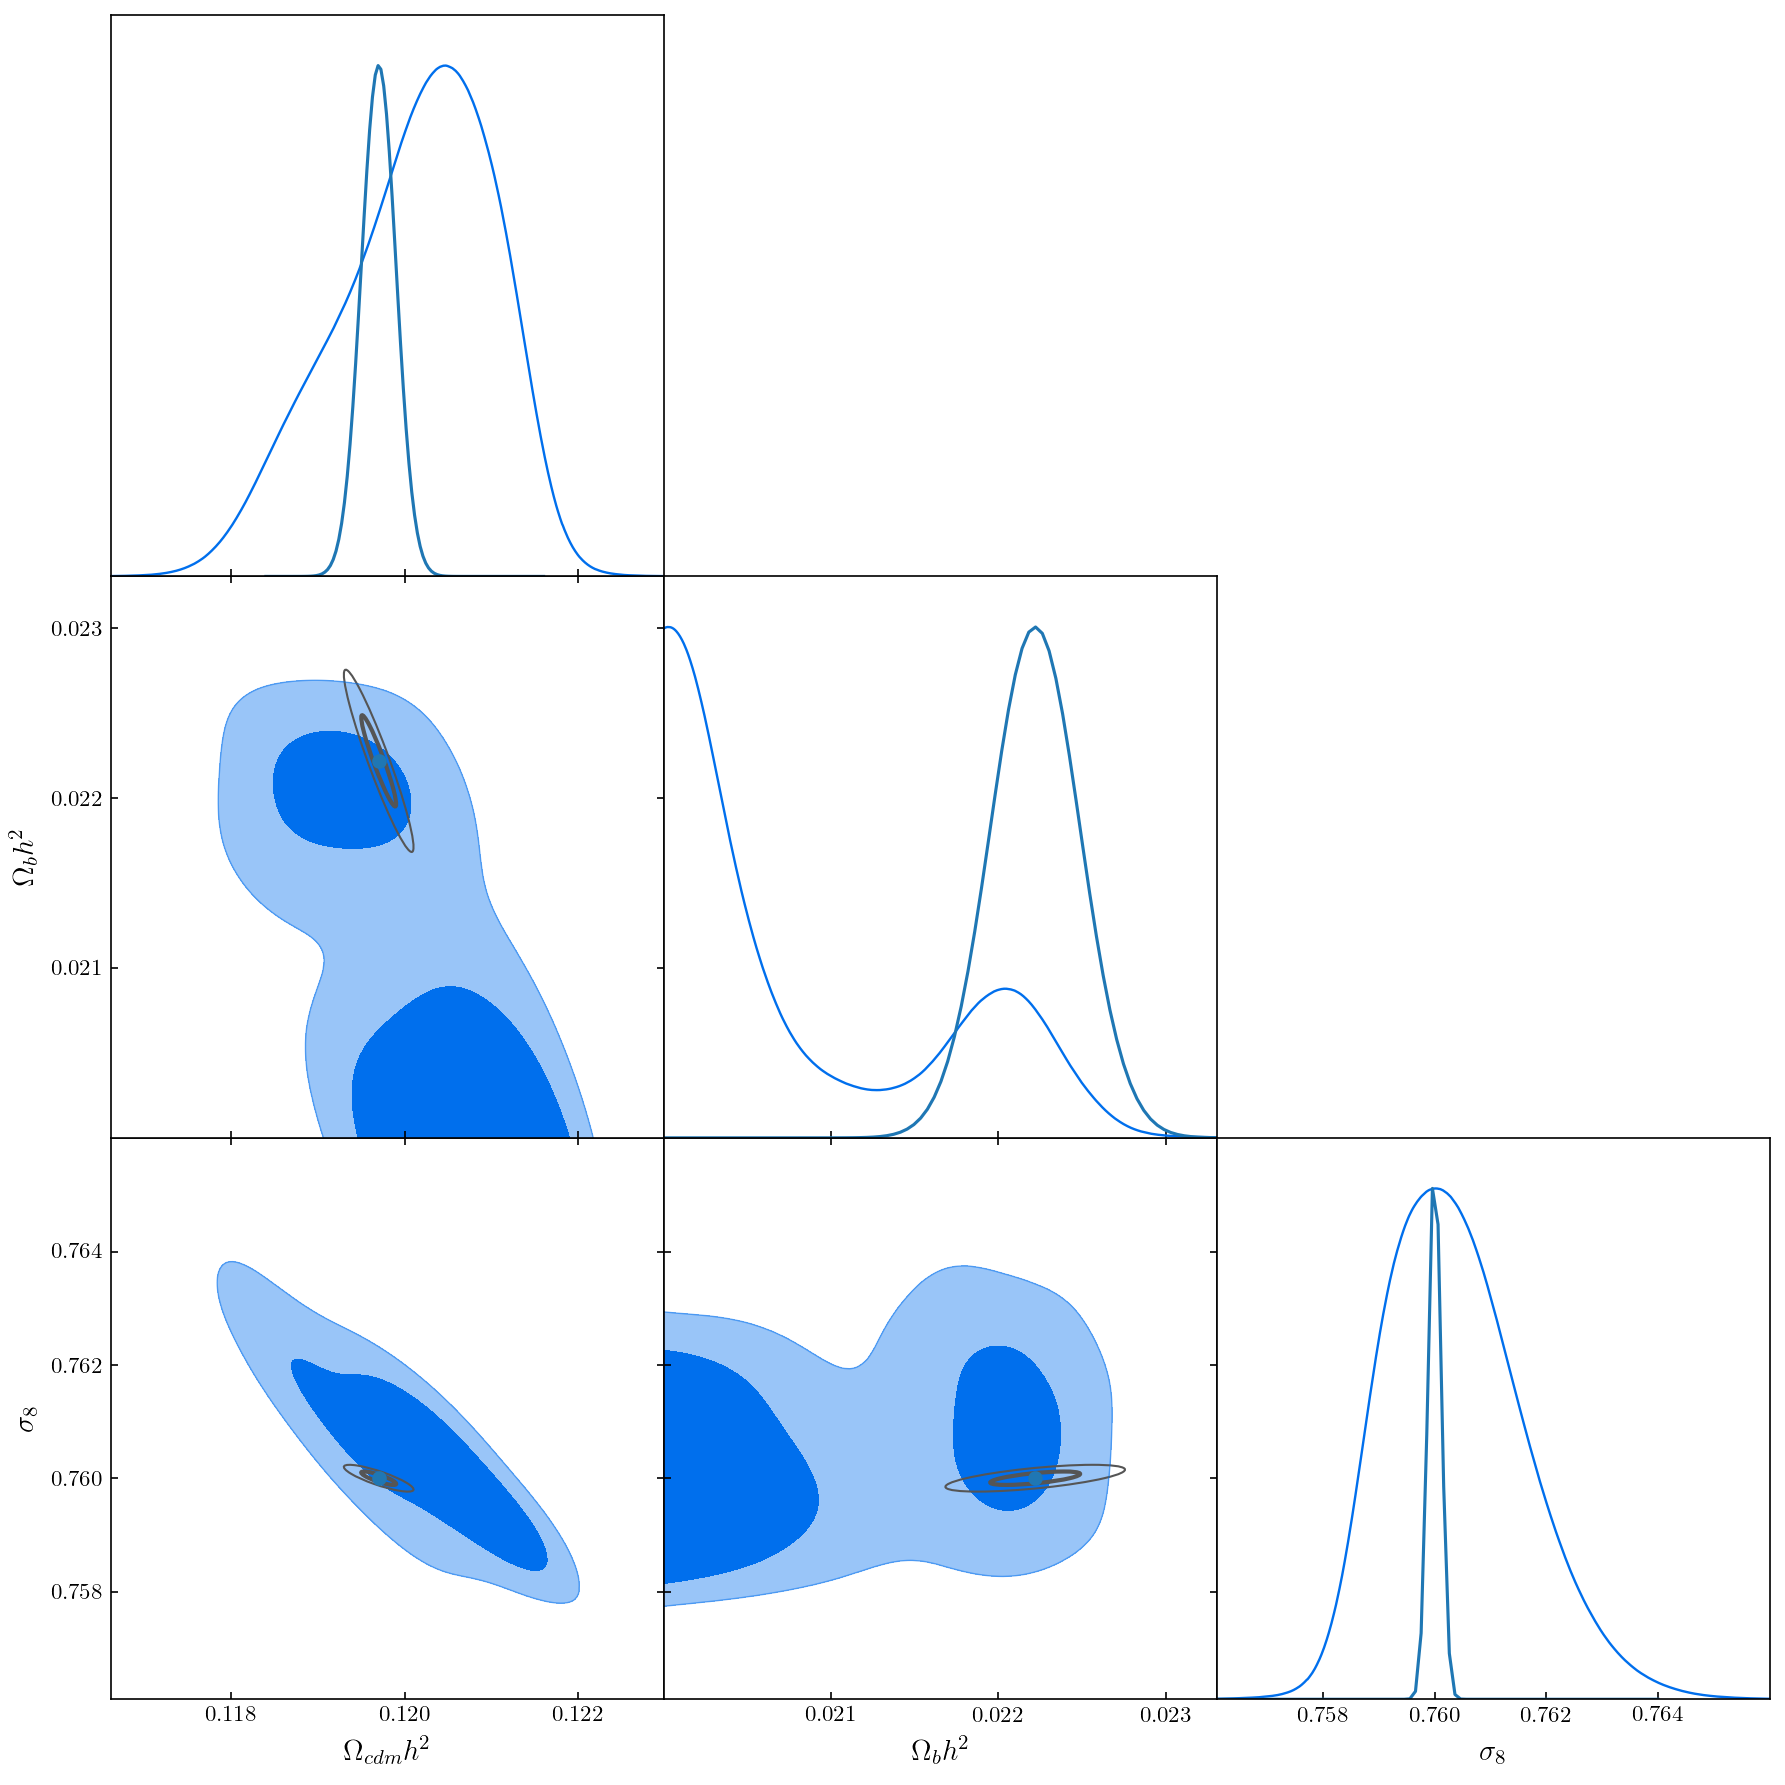

In [53]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot(mc_samples, filled_compare=True, normalized=True)
ax0 = g.subplots[0,0]
#ax.plot(theta_fiducial[0], theta_fiducial[0], marker='o', zorder=9, label='estimate')
ax0.plot(theta_cdm, norm_theta_cdm)
ax1 = g.subplots[1,1]
ax1.plot(theta_b, norm_theta_b)
ax2 = g.subplots[2,2]
ax2.plot(theta_s8, norm_theta_s8)

ax01 = g.subplots[1,0]
ax01.plot(theta_fiducial[0], theta_fiducial[1], marker='o', zorder=9, label='estimate')
eigval,eigvec = np.linalg.eig(covariance_matrix[:2, :2])
angle = np.degrees(np.arctan2(eigvec[1,0], eigvec[0,0]))
w,h = 2*np.sqrt(eigval)
for n in [1,2]:
    ax01.add_patch(Ellipse(theta_fiducial[:2], width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))

ax02 = g.subplots[2,0]
ax02.plot(theta_fiducial[0], theta_fiducial[2], marker='o', zorder=9, label='estimate')
covariance_matrix_temp = np.zeros((2, 2))
covariance_matrix_temp[0, 0] = covariance_matrix[0, 0]
covariance_matrix_temp[0, 1] = covariance_matrix[0, 2]
covariance_matrix_temp[1, 0] = covariance_matrix[2, 0]
covariance_matrix_temp[1, 1] = covariance_matrix[2, 2]
theta_fiducial_temp = [theta_fiducial[0], theta_fiducial[2]]
eigval,eigvec = np.linalg.eig(covariance_matrix_temp)
angle = np.degrees(np.arctan2(eigvec[1,0], eigvec[0,0]))
w,h = 2*np.sqrt(eigval)
for n in [1,2]:
    ax02.add_patch(Ellipse(theta_fiducial_temp, width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))


ax03 = g.subplots[2,1]
ax03.plot(theta_fiducial[1], theta_fiducial[2], marker='o', zorder=9, label='estimate')
eigval,eigvec = np.linalg.eig(covariance_matrix[1:, 1:])
angle = np.degrees(np.arctan2(eigvec[1,0], eigvec[0,0]))
w,h = 2*np.sqrt(eigval)
for n in [1,2]:
    ax03.add_patch(Ellipse(theta_fiducial[1:], width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))

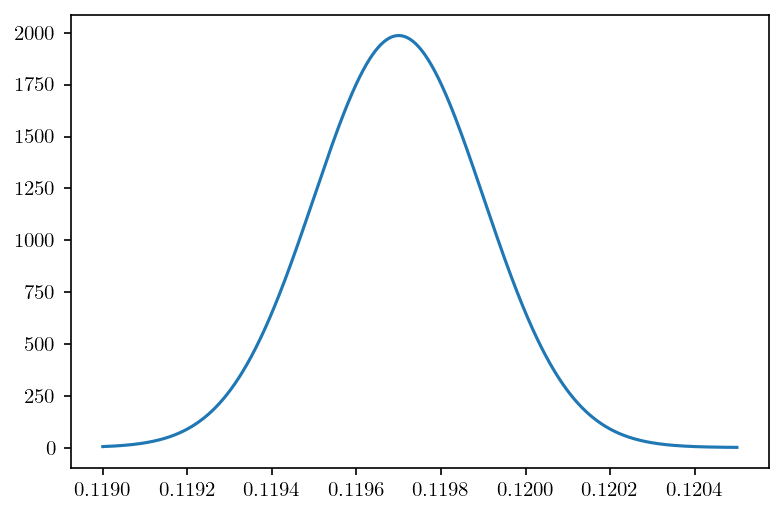

In [58]:
import matplotlib.pyplot as plt
theta_cdm_temp = np.linspace(0.1190, 0.1205, 1000)
plt.figure()
plt.plot(theta_cdm_temp, norm.pdf(theta_cdm_temp, theta_fiducial[0], np.sqrt(covariance_matrix[0, 0])))

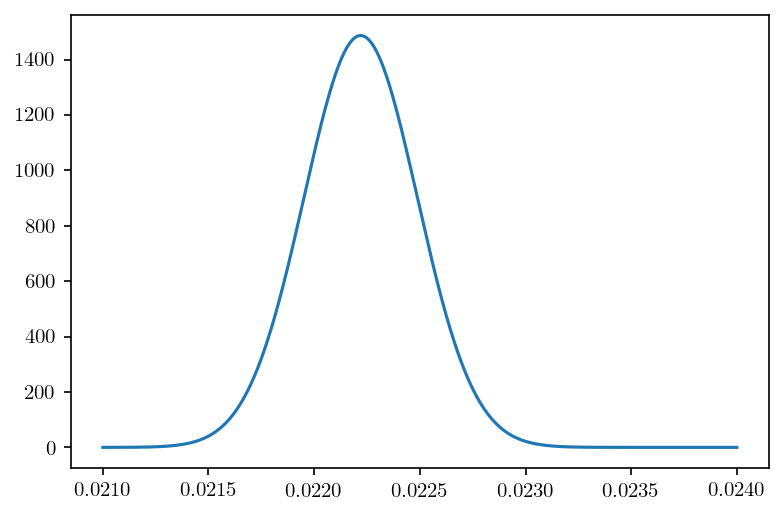

In [64]:
theta_b_temp = np.linspace(0.021, 0.024, 1000)
plt.figure()
plt.plot(theta_b_temp, norm.pdf(theta_b_temp, theta_fiducial[1], np.sqrt(covariance_matrix[1, 1])))

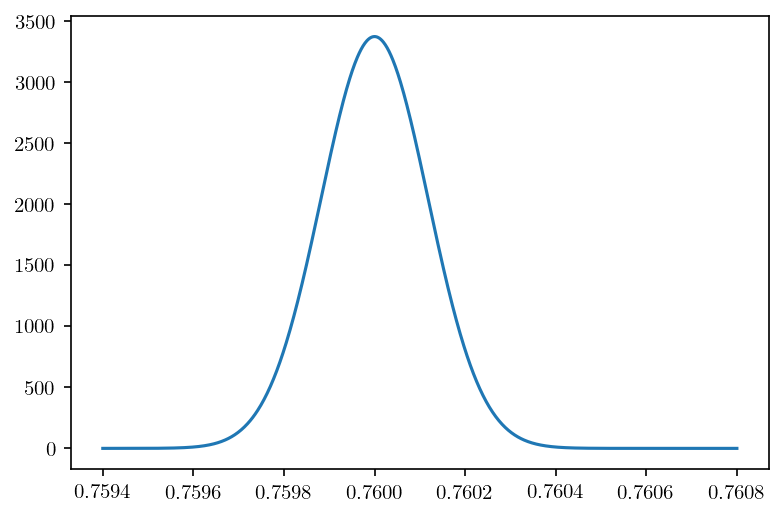

In [63]:
theta_s8_temp = np.linspace(0.7594, 0.7608, 1000)
plt.figure()
plt.plot(theta_s8_temp, norm.pdf(theta_s8_temp, theta_fiducial[2], np.sqrt(covariance_matrix[2, 2])))